<a href="https://colab.research.google.com/github/karlamendes0/Analise-de-sentimentos-de-tweet/blob/main/An%C3%A1lise_de_sentimentos_de_tweet_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Processamento de Linguagem Natural (PNL):** Disciplina da ciência da computação, inteligência artificial e linguística que se preocupa com a criação de modelos computacionais que processam e compreendem a linguagem natural. Isso inclui: fazer o computador entender o agrupamento semântico de palavras (por exemplo, gato e cachorro são semanticamente mais parecidos que gato e colher), conversão de texto em fala, tradução de idiomas e muito mais

**Análise de Sentimento:** É a interpretação e classificação de emoções (positivas, negativas e neutras) em dados de texto utilizando técnicas de análise de texto. A análise de sentimento permite que as organizações identifiquem o sentimento público em relação a determinadas palavras ou tópicos.

Neste caderno, desenvolveremos um modelo de Análise de Sentimento para categorizar um tweet como Positivo ou Negativo.

#Dataset
o dataset escolhido foi "Sentiment140 dataset with 1.6 million tweets".
Ele contém 1.600.000 tweets extraídos usando a API do Twitter. Os tweets foram anotados (0 = negativo, 2 = neutro, 4 = positivo) e podem ser usados ​​para detectar sentimentos. Foi criado por alunos de Stanford,  e essa rotulação possibilita a detecção automatizada de sentimentos nas mensagens, tornando o conjunto de dados extremamente útil para pesquisas no campo da análise de sentimentos em redes sociais.

O conjunto de dados é composto por seis campos principais:

target: A polaridade da mensagem, onde 0 representa sentimentos negativos, 2 indica sentimentos neutros e 4 reflete sentimentos positivos.

ids: O identificador único associado a cada tweet.

date: A data e hora em que o tweet foi publicado no formato UTC (por exemplo, Sat May 16 23:58:44 UTC 2009).

flag: A query utilizada para extrair o tweet. Se não houver query, o valor é NO_QUERY.

user: O usuário que publicou o tweet.

text: O próprio conteúdo do tweet.

Os criadores do dataset adotaram uma abordagem única na geração dos dados de treinamento, diferenciando-se ao criar automaticamente o conjunto, em oposição à abordagem tradicional de anotação manual por humanos. No método empregado, a equipe assumiu que tweets contendo emoticons positivos, como :), eram considerados positivos, enquanto tweets com emoticons negativos, como :(), eram considerados negativos. A coleta desses tweets foi realizada por meio da API de Busca do Twitter, utilizando palavras-chave específicas.

A abordagem inovadora dos criadores proporciona uma perspectiva única e automatizada para a criação de dados de treinamento, destacando a eficácia do uso de emoticons como indicadores de sentimento.


citação: Go, A., Bhayani, R. e Huang, L., 2009. Classificação de sentimento do Twitter usando supervisão distante. Relatório do Projeto CS224N, Stanford, 1(2009), p.12.


link: https://www.kaggle.com/datasets/kazanova/sentiment140


#Importando as bibliotecas

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"karlamendes","key":"5c1c9524c30acf7c968a5fbbf2f29de4"}'}

In [3]:
!rm -Rf sample_data/
!chmod 600 kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d kazanova/sentiment140
!unzip sentiment140.zip
!rm -Rf sentiment140.zip

 99% 80.0M/80.9M [00:03<00:00, 32.9MB/s]
100% 80.9M/80.9M [00:03<00:00, 24.2MB/s]
Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [4]:
!pip install keras==2.15.0 --upgrade
!pip install pandas==1.5.3 --upgrade
!pip install transformers

In [5]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
# nltk
from nltk.stem import WordNetLemmatizer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Usando o back-end do TensorFlow.


In [6]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

#Lendo o dataset


In [8]:
dataset_filename = "training.1600000.processed.noemoticon.csv"
df = pd.read_csv(dataset_filename, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [9]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [10]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


sentimentos

0 -> NEGATIVE

2 -> NEUTRAL

4 -> POSITIVE


In [11]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [12]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 365 ms, sys: 0 ns, total: 365 ms
Wall time: 363 ms



Estamos traçando a distribuição do conjunto de dados para ver se temos um número igual de tweets positivos e negativos ou não.

Text(0.5, 1.0, 'Dataset labels distribuition')

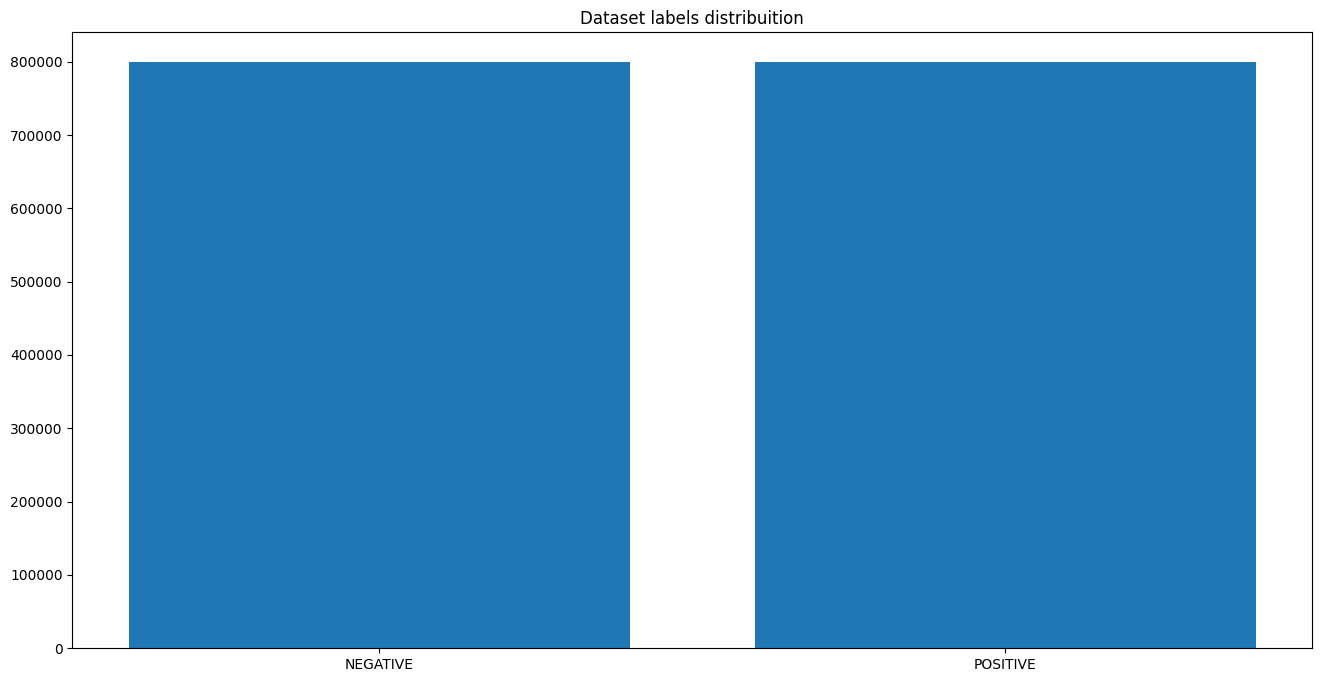

In [13]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

Como podemos ver nos gráficos, temos igual número de tweets Positivos/Negativos. Ambos equivalendo a 800.000 tweets. Isso significa que nosso conjunto de dados não está distorcido, o que torna o trabalho no conjunto de dados mais fácil para nós.

#Pre-processamento
O pré-processamento de texto é tradicionalmente uma etapa importante para tarefas de processamento de linguagem natural (PNL). Ele transforma o texto em um formato mais digerível para que os algoritmos de aprendizado profundo possam ter um melhor desempenho.

Os tweets geralmente contêm muitas informações além do texto, como menções, hashtags, urls, emojis ou símbolos. Como normalmente os modelos de PNL não conseguem analisar esses dados, precisamos limpar o tweet e substituir os tokens que realmente contêm informações significativas para o modelo.

Realizamos limpeza e transformações no texto original, removendo elementos indesejados, dividindo em palavras, removendo stop words e, opcionalmente, aplicando stemização para reduzir as palavras à sua forma base. Esse tipo de pré-processamento é comumente usado para preparar dados de texto antes de aplicar modelos de análise de sentimento, classificação de texto, entre outras tarefas de processamento de linguagem natural (PLN).


As etapas de pré-processamento realizadas são:


- Minúsculas: Cada texto é convertido em minúsculas.
- Remoção de Links, Usuários e Caracteres Especiais
-  redução as palavras à sua forma base.

De forma detalhada, fizemos:

Remoção de Links, Usuários e Caracteres Especiais:
A expressão regular TEXT_CLEANING_RE é usada para substituir links, menções de usuários e caracteres especiais por espaços em branco.
Isso ajuda a remover informações irrelevantes ou ruidosas do texto.

Tokenização:
O texto é dividido em palavras individuais (tokens) usando a função split().
Cada palavra é considerada como um token.

    for token in text.split():


Remoção de Stop Words:
As stop words (palavras comuns que geralmente são removidas durante a análise de texto) são removidas do conjunto de tokens.
As stop words são definidas pela lista stop_words.

    if token not in stop_words:

Stemização (opcional):
Se a opção stem for True, cada token é reduzido ao seu radical usando um processo chamado stemização. A stemização ajuda a reduzir palavras à sua forma base.
Isso é feito usando um stemmer da NLTK (Natural Language Toolkit).
python

    if stem:
    tokens.append(stemmer.stem(token))
else:
    tokens.append(token)

Reconstrução do Texto:
Os tokens resultantes são reunidos novamente em uma única string, usando espaços como separadores.

    return " ".join(tokens)

In [14]:
#Pre - processamento

In [15]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [16]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [17]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 46.5 s, sys: 40.8 ms, total: 46.5 s
Wall time: 46.5 s


In [18]:
dataset_filename = "training.1600000.processed.noemoticon.csv"

# Leia o arquivo CSV original
df_original = pd.read_csv(dataset_filename, encoding='latin1', names=['target', 'text'])
# Aplica o pré-processamento ao texto
df_original['text'] = df_original['text'].apply(lambda x: preprocess(x))

# Exibe as primeiras 5 linhas do DataFrame com o texto pré-processado
print(df_original.head())

                                                             target  \
0 1467810369 Mon Apr 06 22:19:45 PDT 2009 NO_QUERY  _TheSpecialOne_   
  1467810672 Mon Apr 06 22:19:49 PDT 2009 NO_QUERY    scotthamilton   
  1467810917 Mon Apr 06 22:19:53 PDT 2009 NO_QUERY         mattycus   
  1467811184 Mon Apr 06 22:19:57 PDT 2009 NO_QUERY          ElleCTF   
  1467811193 Mon Apr 06 22:19:57 PDT 2009 NO_QUERY           Karoli   

                                                                                                 text  
0 1467810369 Mon Apr 06 22:19:45 PDT 2009 NO_QUERY       awww bummer shoulda got david carr third day  
  1467810672 Mon Apr 06 22:19:49 PDT 2009 NO_QUERY  upset update facebook texting might cry result...  
  1467810917 Mon Apr 06 22:19:53 PDT 2009 NO_QUERY  dived many times ball managed save 50 rest go ...  
  1467811184 Mon Apr 06 22:19:57 PDT 2009 NO_QUERY                   whole body feels itchy like fire  
  1467811193 Mon Apr 06 22:19:57 PDT 2009 NO_QUERY   

In [19]:
df.head(5)

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset update facebook texting might cry result...
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save 50 rest go ...
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behaving mad see


#dividindo os dados
Os modelos de Machine Learning são treinados e testados em diferentes conjuntos de dados. Isso é feito para reduzir a chance de o modelo se ajustar demais aos dados de treinamento, ou seja, ele se ajusta bem ao conjunto de dados de treinamento, mas tem um ajuste ruim com os novos.

 A função train_test_split da biblioteca scikit-learn é uma ferramenta valiosa que permite realizar essa divisão de maneira eficiente.

Os dados pré-processados ​​são divididos em 2 conjuntos de dados:


(Training Data) - Dados de treinamento

(Test Data)- Dados de teste

Vamos examinar os parâmetros-chave:

- df: O DataFrame que contém os dados a serem divididos.
- test_size=1-TRAIN_SIZE: Especifica a proporção do conjunto de teste em relação ao conjunto total. Aqui, 1-TRAIN_SIZE reflete a proporção do conjunto de teste, onde TRAIN_SIZE representa a proporção do conjunto de treinamento.
- random_state=42: Define a semente para garantir reprodutibilidade na divisão dos dados.


Exemplo Numérico:

o DataFrame original df tem 1.600.000 exemplos. Se a constante TRAIN_SIZE for definida como 0,8 (80%), o conjunto de treinamento (df_train) receberá 1.280.000 exemplos, enquanto o conjunto de teste (df_test) receberá 320.000 exemplos. Essa proporção é derivada da diferença entre 1 (o conjunto total) e TRAIN_SIZE.

In [20]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


O resultado indica que o conjunto de treinamento (df_train) possui 1.280.000 exemplos e o conjunto de teste (df_test) possui 320.000 exemplos. Isso reflete a divisão do DataFrame original df de acordo com a proporção especificada.

#Word2Vec

Word2Vec foi desenvolvido pelo Google e é uma das técnicas mais populares para aprender incorporações de palavras usando rede neural superficial. Word2Vec pode criar embeddings de palavras usando dois métodos (ambos envolvendo redes neurais): Skip Gram e Common Bag Of Words (CBOW). Nesse [artigo](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa) explica melhor sobre o Word2Vec.

In [21]:
%%time
documents = [_text.split() for _text in df_train.text]

CPU times: user 3.33 s, sys: 393 ms, total: 3.72 s
Wall time: 3.7 s


In [22]:
w2v_model = gensim.models.Word2Vec(vector_size=W2V_SIZE,
                                   window=W2V_WINDOW,
                                   min_count=W2V_MIN_COUNT,
                                   workers=8)

In [23]:
w2v_model.build_vocab(documents)

In [24]:
words = w2v_model.wv.key_to_index
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [25]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 18min 15s, sys: 3.83 s, total: 18min 19s
Wall time: 3min 15s


(263126437, 295270528)

In [26]:
w2v_model.wv.most_similar("love")

[('luv', 0.5713581442832947),
 ('loves', 0.5516037940979004),
 ('loved', 0.5352730751037598),
 ('adore', 0.5166755318641663),
 ('amazing', 0.5026878118515015),
 ('looove', 0.5022915005683899),
 ('awesome', 0.4714600443840027),
 ('lovee', 0.4644991457462311),
 ('loveee', 0.4555101990699768),
 ('miss', 0.43825602531433105)]

In [27]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 14.5 s, sys: 107 ms, total: 14.6 s
Wall time: 14.5 s


In [28]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 20.7 s, sys: 526 ms, total: 21.2 s
Wall time: 21.2 s


#encoder

In [29]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [30]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [31]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


#Embedding

In [32]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [33]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False) #criar camada de embedding

#construcao da rnn LSTM

In [34]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          87125700  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 87286201 (332.97 MB)
Trainable params: 160501 (626.96 KB)
Non-trainable params: 87125700 (332.36 MB)
_________________________________________________________________


#compilando o modelo

In [35]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy', 'mse']) #metricas da acuracia e mean squared error

#Callbacks

In [36]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0), #reduz o learning reat (taxa de aprendizado)
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)] #caso em 5 epocas se a rnn nao melhorar as metricas o treinamento para

#treinamento

In [38]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4752 - accuracy: 0.7699 - mse: 0.1562

1125/1125 [==============================] - 419s 373ms/step - loss: 0.4752 - accuracy: 0.7699 - mse: 0.1562 - val_loss: 0.4569 - val_accuracy: 0.7847 - val_mse: 0.1486 - lr: 0.0010
Epoch 2/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4690 - accuracy: 0.7737 - mse: 0.1539

1125/1125 [==============================] - 415s 369ms/step - loss: 0.4690 - accuracy: 0.7737 - mse: 0.1539 - val_loss: 0.4524 - val_accuracy: 0.7859 - val_mse: 0.1472 - lr: 0.0010
Epoch 3/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4661 - accuracy: 0.7758 - mse: 0.1528

1125/1125 [==============================] - 415s 369ms/step - loss: 0.4661 - accuracy: 0.7758 - mse: 0.1528 - val_loss: 0.4494 - val_accuracy: 0.7884 - val_mse: 0.1461 - lr: 0.0010
Epoch 4/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4645 - accuracy: 0.7767 - mse: 0.1522

1125/1125 [==============================] - 416s 370ms/step - loss: 0.4645 - accuracy: 0.7767 - mse: 0.1522 - val_loss: 0.4481 - val_accuracy: 0.7887 - val_mse: 0.1457 - lr: 0.0010
Epoch 5/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4625 - accuracy: 0.7777 - mse: 0.1515

1125/1125 [==============================] - 423s 376ms/step - loss: 0.4625 - accuracy: 0.7777 - mse: 0.1515 - val_loss: 0.4472 - val_accuracy: 0.7901 - val_mse: 0.1452 - lr: 0.0010
Epoch 6/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4616 - accuracy: 0.7785 - mse: 0.1511

1125/1125 [==============================] - 421s 375ms/step - loss: 0.4616 - accuracy: 0.7785 - mse: 0.1511 - val_loss: 0.4466 - val_accuracy: 0.7903 - val_mse: 0.1450 - lr: 0.0010
Epoch 7/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4603 - accuracy: 0.7792 - mse: 0.1507

1125/1125 [==============================] - 418s 372ms/step - loss: 0.4603 - accuracy: 0.7792 - mse: 0.1507 - val_loss: 0.4445 - val_accuracy: 0.7916 - val_mse: 0.1443 - lr: 0.0010
Epoch 8/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4601 - accuracy: 0.7795 - mse: 0.1506

1125/1125 [==============================] - 415s 369ms/step - loss: 0.4601 - accuracy: 0.7795 - mse: 0.1506 - val_loss: 0.4456 - val_accuracy: 0.7908 - val_mse: 0.1447 - lr: 0.0010
CPU times: user 1h 4min 2s, sys: 4min 11s, total: 1h 8min 14s
Wall time: 55min 45s


#Evaluate

In [39]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 34s 106ms/step - loss: 0.4445 - accuracy: 0.7913 - mse: 0.1441

ACCURACY: 0.7913093566894531
LOSS: 0.4444677233695984
CPU times: user 27 s, sys: 5.19 s, total: 32.2 s
Wall time: 34 s


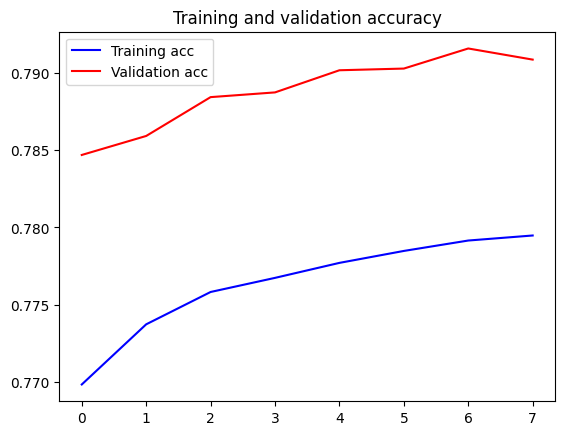

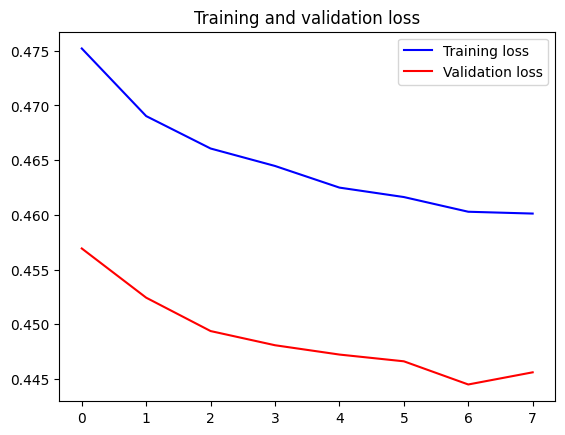

In [40]:
acc = history.history['accuracy']  # ou 'acc' dependendo da biblioteca e versão
val_acc = history.history['val_accuracy']  # ou 'val_acc' dependendo da biblioteca e versão
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


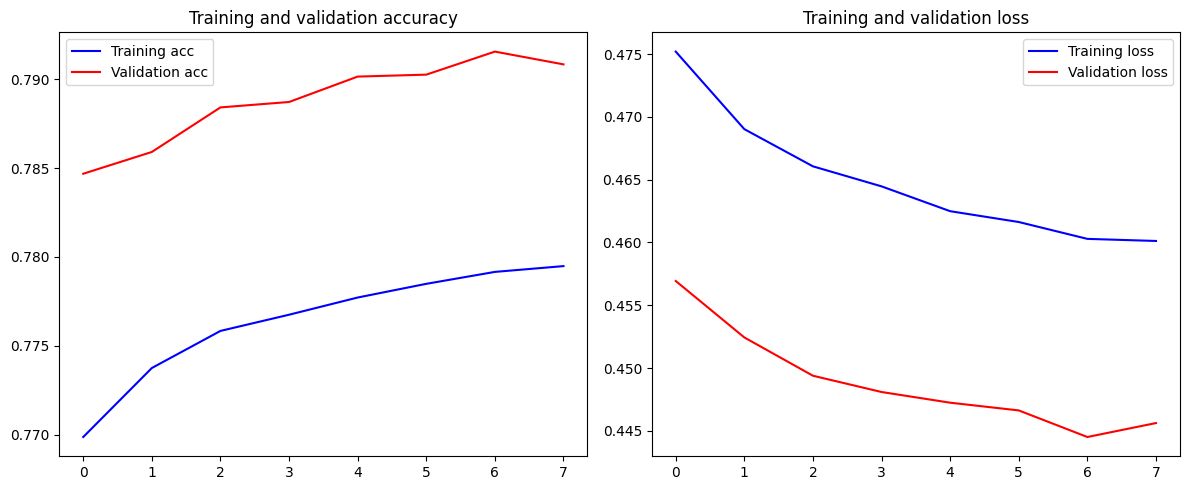

In [41]:
acc = history.history['accuracy']  # ou 'acc' dependendo da biblioteca e versão
val_acc = history.history['val_accuracy']  # ou 'val_acc' dependendo da biblioteca e versão
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.tight_layout()
plt.show()


#predict

In [42]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [43]:

#funcaopredict dado um determinado texto, ela diz o sentimento e acuracia
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [44]:
print(score)

[0.4444677233695984, 0.7913093566894531, 0.14410457015037537]


In [45]:
predict("I love the music")

1/1 [==============================] - 0s 301ms/step


{'label': 'POSITIVE',
 'score': 0.9755124449729919,
 'elapsed_time': 0.34528350830078125}

In [46]:
predict("I hate the rain")

1/1 [==============================] - 0s 87ms/step


{'label': 'NEGATIVE',
 'score': 0.010659527964890003,
 'elapsed_time': 0.12703895568847656}

In [47]:
predict("i don't know what i'm doing")


1/1 [==============================] - 0s 84ms/step


{'label': 'NEGATIVE',
 'score': 0.3314761519432068,
 'elapsed_time': 0.12412071228027344}

#Matriz de confusão

In [48]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

40/40 [==============================] - 22s 548ms/step
CPU times: user 13.7 s, sys: 9.99 s, total: 23.7 s
Wall time: 23.3 s


In [49]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

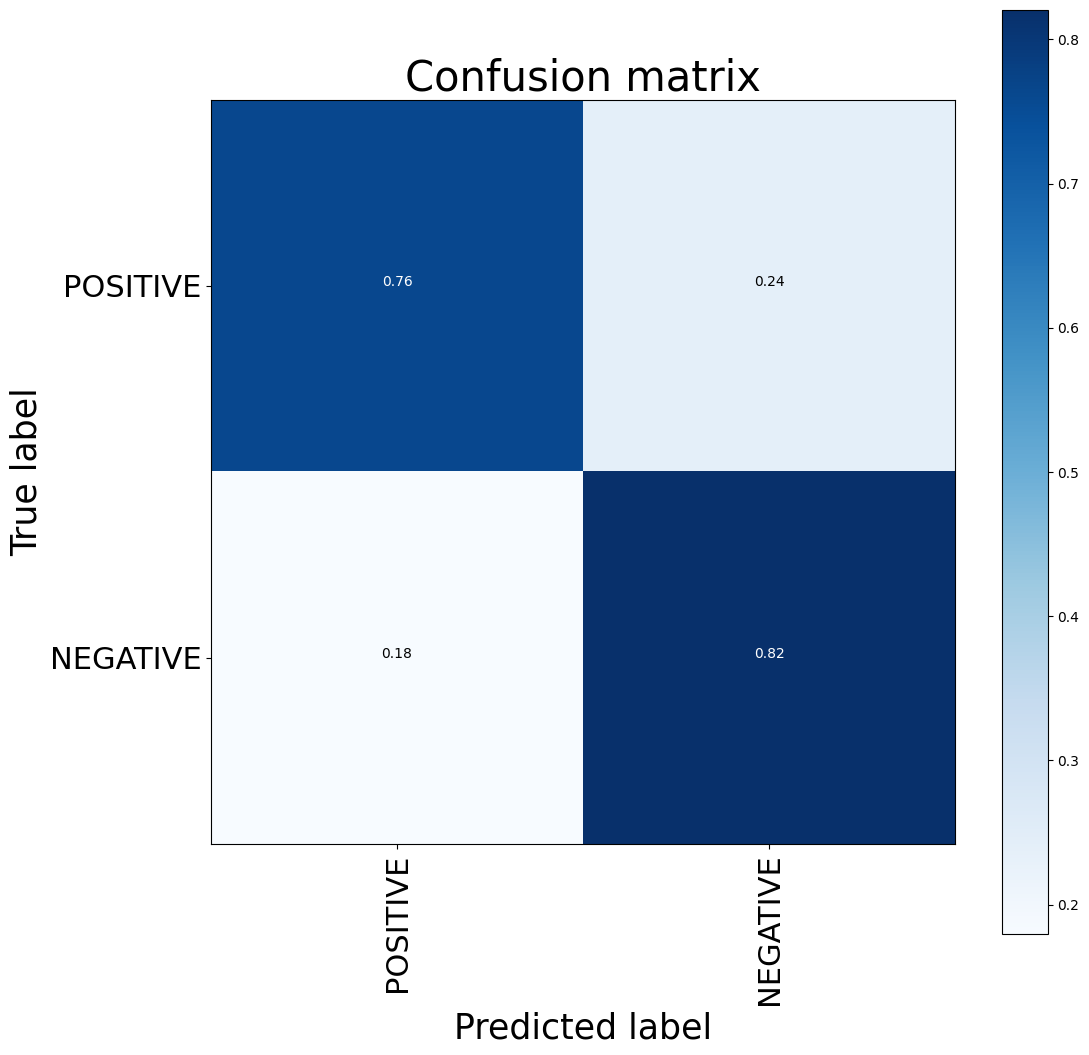

CPU times: user 1.27 s, sys: 427 ms, total: 1.69 s
Wall time: 1.27 s


In [50]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

#Classification Report

In [51]:
print(classification_report(y_test_1d, y_pred_1d))


              precision    recall  f1-score   support

    NEGATIVE       0.81      0.76      0.78    159494
    POSITIVE       0.78      0.82      0.80    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



In [78]:
pip install scikit-learn


In [81]:
from sklearn.metrics import accuracy_score

# Considere que 'y_test_1d' contém as verdadeiras classes e 'y_pred_1d' contém as classes previstas pelo modelo LSTM
accuracy = accuracy_score(y_test_1d, y_pred_1d)

print(f'Acurácia do modelo LSTM: {accuracy * 100:.2f}%')


Acurácia do modelo LSTM: 79.13%


#extraindo as metricas individuais




In [52]:
from sklearn.metrics import classification_report

# Supondo que y_test_1d seja seu conjunto de teste e y_pred_1d sejam as previsões do seu modelo
report = classification_report(y_test_1d, y_pred_1d, output_dict=True)

# Para acessar as métricas individuais:
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']
accuracy = report['accuracy']

# Imprimindo as métricas
print(f"Precisão: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1_score:.2f}")
print(f"Acurácia: {accuracy:.2f}")



Precisão: 0.79
Recall: 0.79
F1-Score: 0.79
Acurácia: 0.79


#modelos de classificação

- LinearSVC Model
- Logistic Regression Model
- BernoulliNB
- arvore de decisao

Como nosso conjunto de dados não é distorcido, ou seja, possui número igual de previsões positivas e negativas. Estamos escolhendo Precisão como nossa métrica de avaliação. Além disso, estamos traçando a Matriz de Confusão para entender o desempenho de nosso modelo em ambos os tipos de classificação.

In [61]:

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
import seaborn as sns

In [62]:
def model_Evaluate(model):

    # Predict values for Test dataset
    y_pred = model.predict(x_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

#LinearSVC Model

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.50      0.90      0.64    159494
           1       0.50      0.10      0.17    160506

    accuracy                           0.50    320000
   macro avg       0.50      0.50      0.40    320000
weighted avg       0.50      0.50      0.40    320000



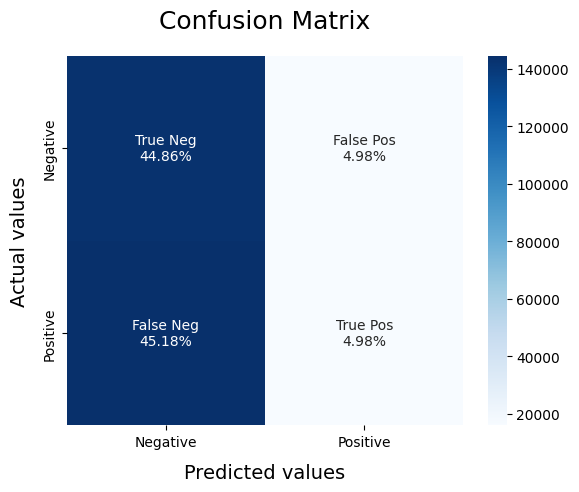

In [63]:
SVCmodel = LinearSVC()
SVCmodel.fit(x_train, y_train)
model_Evaluate(SVCmodel)

In [82]:
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC

# Crie e treine o modelo SVC
SVCmodel = LinearSVC()
SVCmodel.fit(x_train, y_train)

# Faça previsões no conjunto de teste
y_pred_svc = SVCmodel.predict(x_test)

# Calcule a acurácia
accuracy_svc = accuracy_score(y_test, y_pred_svc)

print(f'Acurácia do modelo SVC: {accuracy_svc * 100:.2f}%')


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Acurácia do modelo SVC: 50.36%


#Logistic Regression Model

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.50      0.02      0.04    159494
           1       0.50      0.98      0.66    160506

    accuracy                           0.50    320000
   macro avg       0.50      0.50      0.35    320000
weighted avg       0.50      0.50      0.35    320000



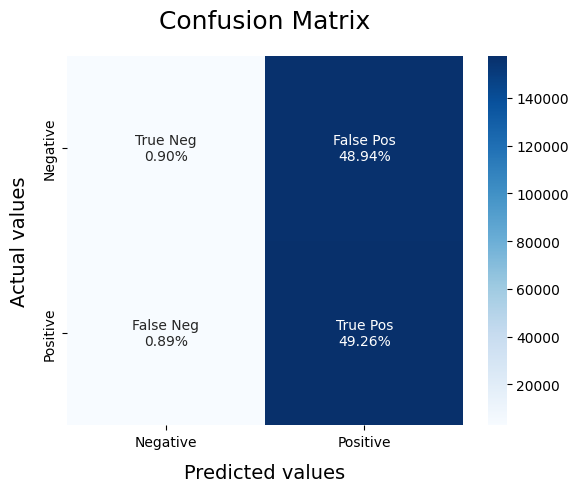

In [64]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(x_train, y_train)
model_Evaluate(LRmodel)

In [95]:
# Faça previsões no conjunto de teste
y_pred_lr = LRmodel.predict(x_test)

# Avalie o modelo e obtenha a acurácia
accuracy_lr = accuracy_score(y_test, y_pred_lr)


print(f'Acurácia do modelo de Regressão Logística: {accuracy * 100:.2f}%')

Acurácia do modelo de Regressão Logística: 59.96%


#BernoulliNB

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.51      0.43      0.47    159494
           1       0.51      0.60      0.55    160506

    accuracy                           0.51    320000
   macro avg       0.51      0.51      0.51    320000
weighted avg       0.51      0.51      0.51    320000



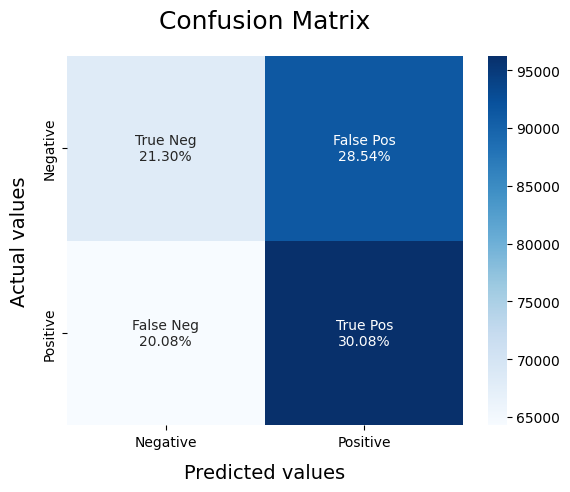

In [65]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(x_train, y_train)
model_Evaluate(BNBmodel)

In [97]:

# Faça previsões no conjunto de teste
y_pred_bnb = BNBmodel.predict(x_test)

# Avalie o modelo e obtenha a acurácia
accuracy_bnb = accuracy_score(y_test, y_pred_bnb)

print(f'Acurácia do modelo Bernoulli Naive Bayes: {accuracy * 100:.2f}%')

Acurácia do modelo Bernoulli Naive Bayes: 59.96%


#arvore de decisao




In [71]:
pip install scikit-learn


              precision    recall  f1-score   support

           0       0.60      0.60      0.60    159494
           1       0.60      0.60      0.60    160506

    accuracy                           0.60    320000
   macro avg       0.60      0.60      0.60    320000
weighted avg       0.60      0.60      0.60    320000



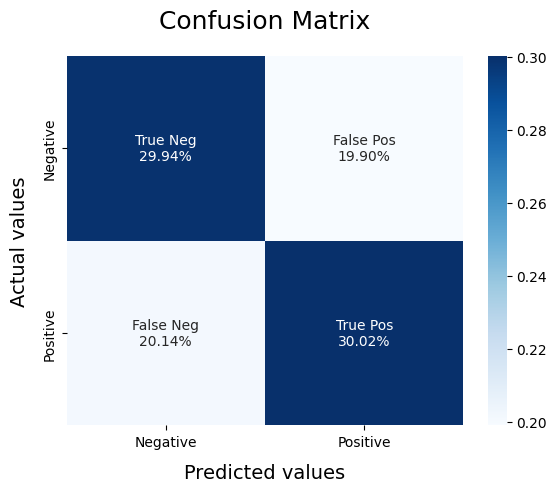

In [75]:
from sklearn.tree import DecisionTreeClassifier

DTmodel = DecisionTreeClassifier()
DTmodel.fit(x_train, y_train)
model_Evaluate(DTmodel, x_test, y_test)

In [99]:

# Faça previsões no conjunto de teste
y_pred_dt = DTmodel.predict(x_test)

# Avalie o modelo e obtenha a acurácia
accuracy_dt = accuracy_score(y_test, y_pred_dt)

print(f'Acurácia do modelo Decision Tree: {accuracy * 100:.2f}%')

Acurácia do modelo Decision Tree: 59.96%


#comparando resultados dos modelos

In [100]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Defina as métricas e previsões conforme necessário
accuracy_lstm = accuracy_score(y_test_1d, y_pred_1d)
precision_lstm = precision_score(y_test_1d, y_pred_1d, average='weighted')
recall_lstm = recall_score(y_test_1d, y_pred_1d, average='weighted')
f1_lstm = f1_score(y_test_1d, y_pred_1d, average='weighted')
report_lstm = classification_report(y_test_1d, y_pred_1d, target_names=df_train.target.unique(), output_dict=True)

# Resultados dos modelos
results = {
    'Modelo': ['LSTM', 'LinearSVC', 'Regressão Logística', 'BernoulliNB', 'Árvore de Decisão'],
    'Acurácia': [accuracy_lstm*100, accuracy_svc*100, accuracy_lr*100, accuracy_bnb*100, accuracy_dt*100],
    'Precision': [report_lstm['weighted avg']['precision'], precision_score(y_test, y_pred_svc, average='weighted'), precision_score(y_test, y_pred_lr, average='weighted'), precision_score(y_test, y_pred_bnb, average='weighted'), precision_score(y_test, y_pred_dt, average='weighted')],
    'Recall': [report_lstm['weighted avg']['recall'], recall_score(y_test, y_pred_svc, average='weighted'), recall_score(y_test, y_pred_lr, average='weighted'), recall_score(y_test, y_pred_bnb, average='weighted'), recall_score(y_test, y_pred_dt, average='weighted')],
    'F1-Score': [report_lstm['weighted avg']['f1-score'], f1_score(y_test, y_pred_svc, average='weighted'), f1_score(y_test, y_pred_lr, average='weighted'), f1_score(y_test, y_pred_bnb, average='weighted'), f1_score(y_test, y_pred_dt, average='weighted')],
    'Support': [report_lstm['weighted avg']['support'], None, None, None, None]  # Preencha com os valores reais de suporte
}

# Criando o DataFrame
df_results = pd.DataFrame(results)

# Exibindo a tabela
print(df_results)


                Modelo   Acurácia  Precision    Recall  F1-Score   Support
0                 LSTM  79.130938   0.792217  0.791309  0.791122  320000.0
1            LinearSVC  50.360938   0.503545  0.503609  0.482880       NaN
2  Regressão Logística  50.167812   0.502174  0.501678  0.350563       NaN
3          BernoulliNB  51.379375   0.513933  0.513794  0.510154       NaN
4    Árvore de Decisão  59.958125   0.599589  0.599581  0.599582       NaN
